# Monte Carlo Pricer: Performance & Convergence Analysis

This notebook demonstrates the performance characteristics and convergence behavior of the Monte Carlo option pricer with:
- Multi-threading optimization
- SIMD batch processing
- Variance reduction techniques

## Setup Instructions

Before running this notebook, install the module:
```bash
cd c:\CPP\montecarlo-pricer
pip install -e .
```

If you're running this for the first time, the build may take a minute or two.

In [2]:
# Ensure the module is installed
import subprocess
import sys

try:
    import montecarlo_pricer
    print("✓ montecarlo_pricer module found")
except ImportError:
    print("Building and installing montecarlo_pricer module...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "-e", "c:\\CPP\\montecarlo-pricer", "--force-reinstall", "--no-deps"],
        capture_output=True,
        text=True,
        timeout=300
    )
    if result.returncode != 0:
        print("STDOUT:", result.stdout)
        print("STDERR:", result.stderr)
        raise RuntimeError(f"Failed to install module: {result.stderr}")
    print("✓ Module installed successfully")
    import montecarlo_pricer
    print("✓ montecarlo_pricer module loaded")

✓ montecarlo_pricer module found


In [3]:
# Import required libraries
import montecarlo_pricer as mcp
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

## Setup: Create Pricer and Configuration

In [4]:
# Initialize pricer
pricer = mcp.MonteCarloPricer(seed=42)

# Base configuration
config = mcp.PricingConfig()
config.S0 = 100.0
config.K = 100.0
config.r = 0.05
config.sigma = 0.2
config.T = 1.0
config.option_type = "call"
config.use_antithetic = True

# Get analytical price for reference
analytical_price = pricer.analytical_price(config)
print(f"Black-Scholes Analytical Price: {analytical_price:.6f}")

Black-Scholes Analytical Price: 10.450584


## Plot 1: Error vs Paths (Log-Log)

Shows how pricing error decreases as the number of Monte Carlo paths increases. Demonstrates convergence rate of O(1/√N).

Computing convergence data...
Paths:     1,000 | Error: 0.000624 | Std Error: 0.320874
Paths:     5,000 | Error: 0.127317 | Std Error: 0.150032
Paths:    10,000 | Error: 0.140617 | Std Error: 0.101704
Paths:    50,000 | Error: 0.041624 | Std Error: 0.045868
Paths:   100,000 | Error: 0.046136 | Std Error: 0.032916
Paths:   500,000 | Error: 0.005740 | Std Error: 0.014708
Paths: 1,000,000 | Error: 0.015186 | Std Error: 0.010407
Paths: 5,000,000 | Error: 0.001522 | Std Error: 0.004652


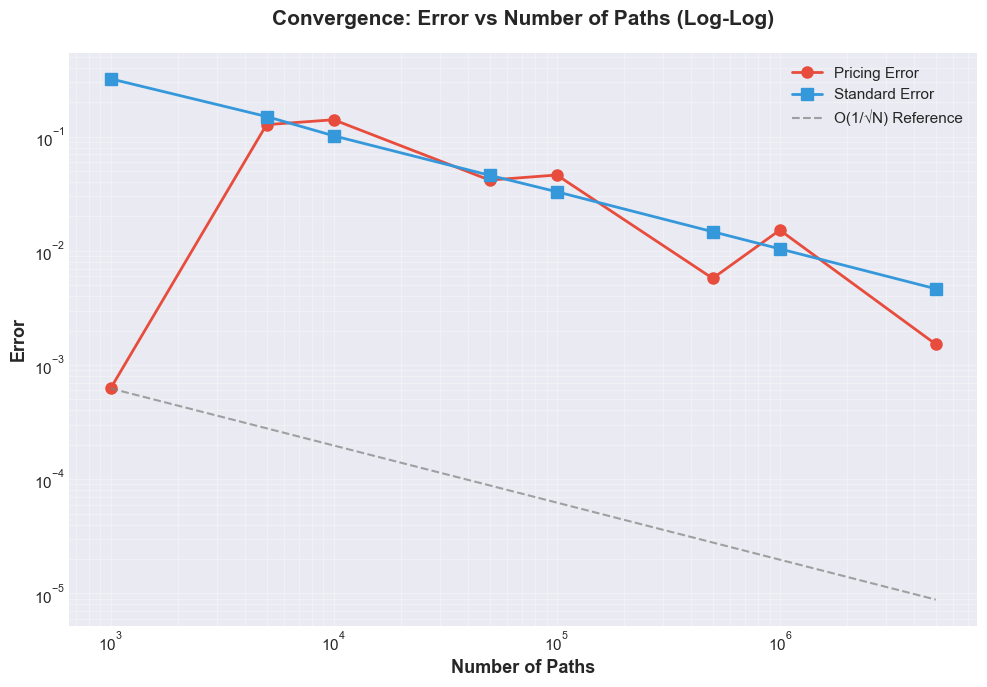


Final error at 5,000,000 paths: 0.001522
Error reduction from 1,000 to 5,000,000 paths: 0.41x


In [5]:
# Test different path counts
path_counts = [1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000, 5_000_000]
errors = []
std_errors = []

config.n_threads = 8  # Use parallel for speed

print("Computing convergence data...")
for n_paths in path_counts:
    config.n_paths = n_paths
    result = pricer.price_mc_parallel(config)
    
    error = abs(result.price - analytical_price)
    errors.append(error)
    std_errors.append(result.std_error)
    
    print(f"Paths: {n_paths:>9,} | Error: {error:.6f} | Std Error: {result.std_error:.6f}")

# Create log-log plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(path_counts, errors, 'o-', linewidth=2, markersize=8, label='Pricing Error', color='#e74c3c')
ax.loglog(path_counts, std_errors, 's-', linewidth=2, markersize=8, label='Standard Error', color='#3498db')

# Add theoretical O(1/√N) reference line
theoretical = [errors[0] * np.sqrt(path_counts[0] / n) for n in path_counts]
ax.loglog(path_counts, theoretical, '--', linewidth=1.5, label='O(1/√N) Reference', color='gray', alpha=0.7)

ax.set_xlabel('Number of Paths', fontsize=13, fontweight='bold')
ax.set_ylabel('Error', fontsize=13, fontweight='bold')
ax.set_title('Convergence: Error vs Number of Paths (Log-Log)', fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='best')
ax.grid(True, which="both", ls="-", alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal error at {path_counts[-1]:,} paths: {errors[-1]:.6f}")
print(f"Error reduction from {path_counts[0]:,} to {path_counts[-1]:,} paths: {errors[0]/errors[-1]:.2f}x")

## Plot 2: Runtime vs Threads

Measures execution time as a function of thread count to identify optimal parallelization.

Benchmarking threading performance...
Threads:  1 | Time: 0.173s | Throughput: 57.8M paths/sec
Threads:  2 | Time: 0.095s | Throughput: 105.2M paths/sec
Threads:  4 | Time: 0.055s | Throughput: 181.2M paths/sec
Threads:  8 | Time: 0.035s | Throughput: 288.7M paths/sec
Threads: 16 | Time: 0.022s | Throughput: 461.0M paths/sec
Threads: 20 | Time: 0.020s | Throughput: 488.0M paths/sec


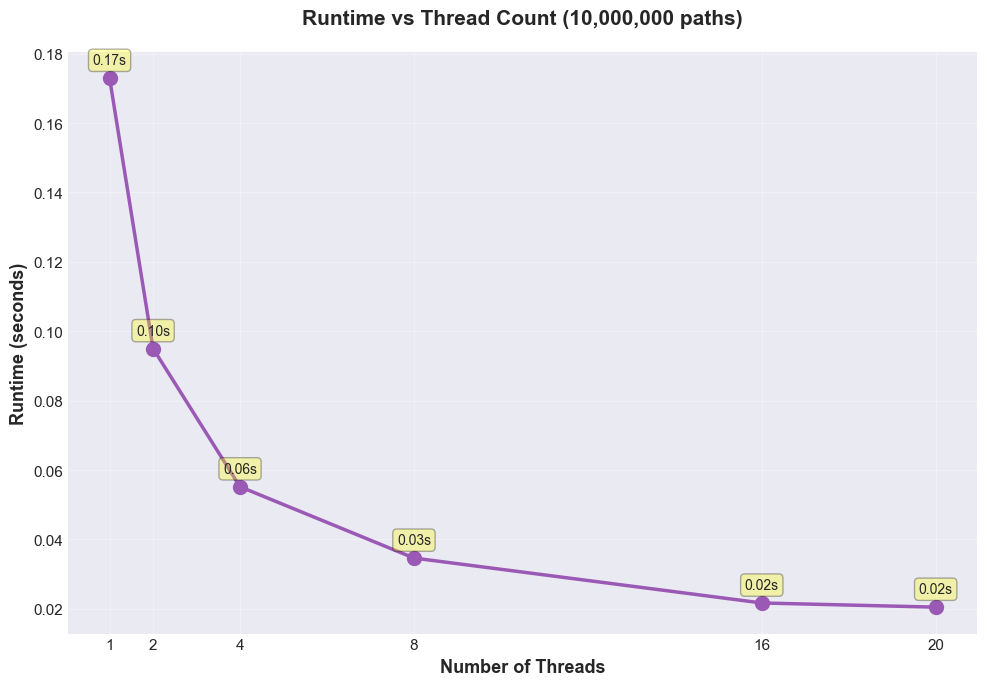


Best runtime: 0.020s with 20 threads
Speedup from 1 to 20 threads: 8.44x


In [6]:
# Test different thread counts
import os
max_threads = os.cpu_count() or 8
thread_counts = [1, 2, 4, 8]
if max_threads >= 16:
    thread_counts.extend([16, max_threads])
elif max_threads > 8:
    thread_counts.append(max_threads)

runtimes = []
config.n_paths = 10_000_000  # Fixed path count for fair comparison

print("Benchmarking threading performance...")
for n_threads in thread_counts:
    config.n_threads = n_threads
    
    start = time.perf_counter()
    result = pricer.price_mc_parallel(config)
    elapsed = time.perf_counter() - start
    
    runtimes.append(elapsed)
    throughput = config.n_paths / elapsed
    
    print(f"Threads: {n_threads:>2} | Time: {elapsed:.3f}s | Throughput: {throughput/1e6:.1f}M paths/sec")

# Create runtime plot
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(thread_counts, runtimes, 'o-', linewidth=2.5, markersize=10, color='#9b59b6')

# Annotate points with values
for i, (threads, runtime) in enumerate(zip(thread_counts, runtimes)):
    ax.annotate(f'{runtime:.2f}s', 
                xy=(threads, runtime), 
                xytext=(0, 10), 
                textcoords='offset points',
                ha='center',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Number of Threads', fontsize=13, fontweight='bold')
ax.set_ylabel('Runtime (seconds)', fontsize=13, fontweight='bold')
ax.set_title(f'Runtime vs Thread Count ({config.n_paths:,} paths)', fontsize=15, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
ax.set_xticks(thread_counts)

plt.tight_layout()
plt.show()

print(f"\nBest runtime: {min(runtimes):.3f}s with {thread_counts[runtimes.index(min(runtimes))]} threads")
print(f"Speedup from 1 to {thread_counts[-1]} threads: {runtimes[0]/runtimes[-1]:.2f}x")

## Plot 3: Speedup Curve

Shows parallel speedup relative to single-threaded execution. Ideal (linear) speedup and actual speedup with efficiency metrics.

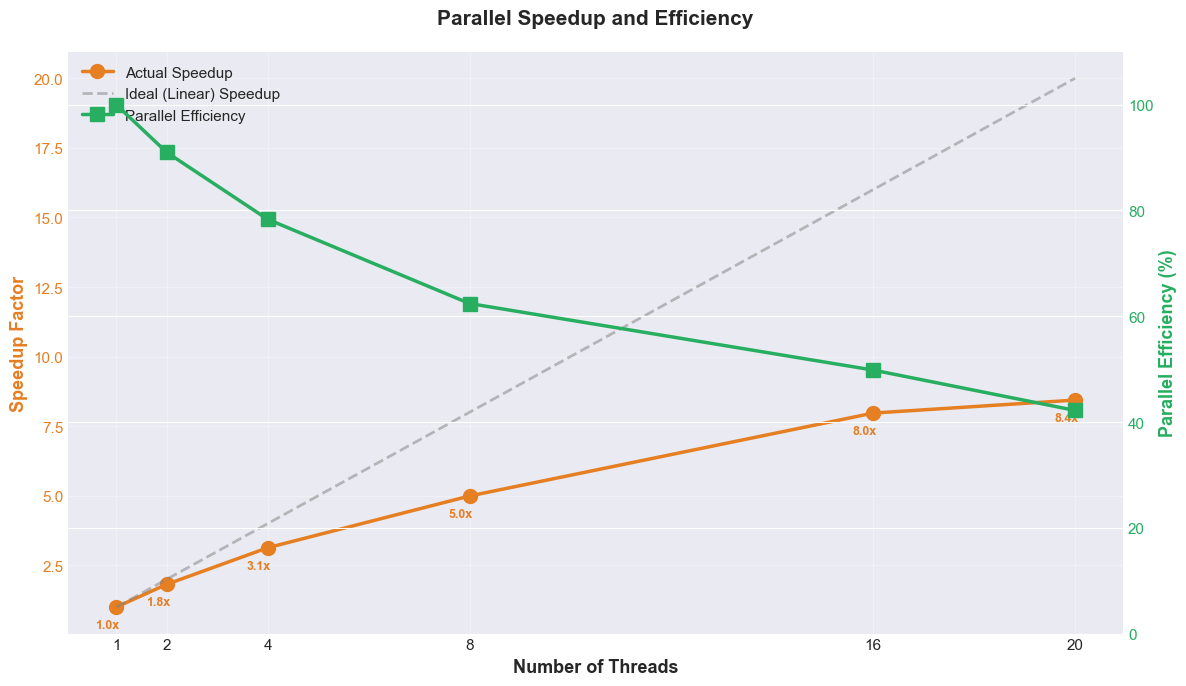


Speedup Summary:
   1 threads:  1.00x speedup, 100.0% efficiency
   2 threads:  1.82x speedup,  91.0% efficiency
   4 threads:  3.13x speedup,  78.3% efficiency
   8 threads:  4.99x speedup,  62.4% efficiency
  16 threads:  7.97x speedup,  49.8% efficiency
  20 threads:  8.44x speedup,  42.2% efficiency


In [7]:
# Calculate speedup and efficiency
base_time = runtimes[0]
speedups = [base_time / t for t in runtimes]
efficiencies = [speedup / threads * 100 for speedup, threads in zip(speedups, thread_counts)]

# Create speedup plot with dual y-axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Speedup on left y-axis
color1 = '#e67e22'
ax1.plot(thread_counts, speedups, 'o-', linewidth=2.5, markersize=10, 
         color=color1, label='Actual Speedup')
ax1.plot(thread_counts, thread_counts, '--', linewidth=2, 
         color='gray', alpha=0.5, label='Ideal (Linear) Speedup')
ax1.set_xlabel('Number of Threads', fontsize=13, fontweight='bold')
ax1.set_ylabel('Speedup Factor', fontsize=13, fontweight='bold', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(thread_counts)
ax1.grid(True, alpha=0.3)

# Efficiency on right y-axis
ax2 = ax1.twinx()
color2 = '#27ae60'
ax2.plot(thread_counts, efficiencies, 's-', linewidth=2.5, markersize=10, 
         color=color2, label='Parallel Efficiency')
ax2.set_ylabel('Parallel Efficiency (%)', fontsize=13, fontweight='bold', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([0, 110])

# Add annotations
for i, (threads, speedup, eff) in enumerate(zip(thread_counts, speedups, efficiencies)):
    ax1.annotate(f'{speedup:.1f}x', 
                xy=(threads, speedup), 
                xytext=(-15, -15), 
                textcoords='offset points',
                fontsize=9,
                color=color1,
                fontweight='bold')

ax1.set_title('Parallel Speedup and Efficiency', fontsize=15, fontweight='bold', pad=20)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=11)

plt.tight_layout()
plt.show()

print("\nSpeedup Summary:")
for threads, speedup, eff in zip(thread_counts, speedups, efficiencies):
    print(f"  {threads:>2} threads: {speedup:>5.2f}x speedup, {eff:>5.1f}% efficiency")

## Plot 4: Standard Error vs Variance Reduction Technique

Compares the effectiveness of different variance reduction methods in reducing estimation error.

Testing variance reduction techniques...

Standard MC                    Std Error: 0.014736, VR Factor: 1.00x
Antithetic
Variates            Std Error: 0.010362, VR Factor: 1.42x
Control Variate
(β=1, Sanity Check) Std Error: 0.014735, VR Factor: 1.00x
  └─ Control:                  β=1.00, Var.Red.=1.00x
Antithetic
+ Control           Std Error: 0.010457, VR Factor: 1.41x
  └─ Control:                  β=1.00, Var.Red.=0.99x


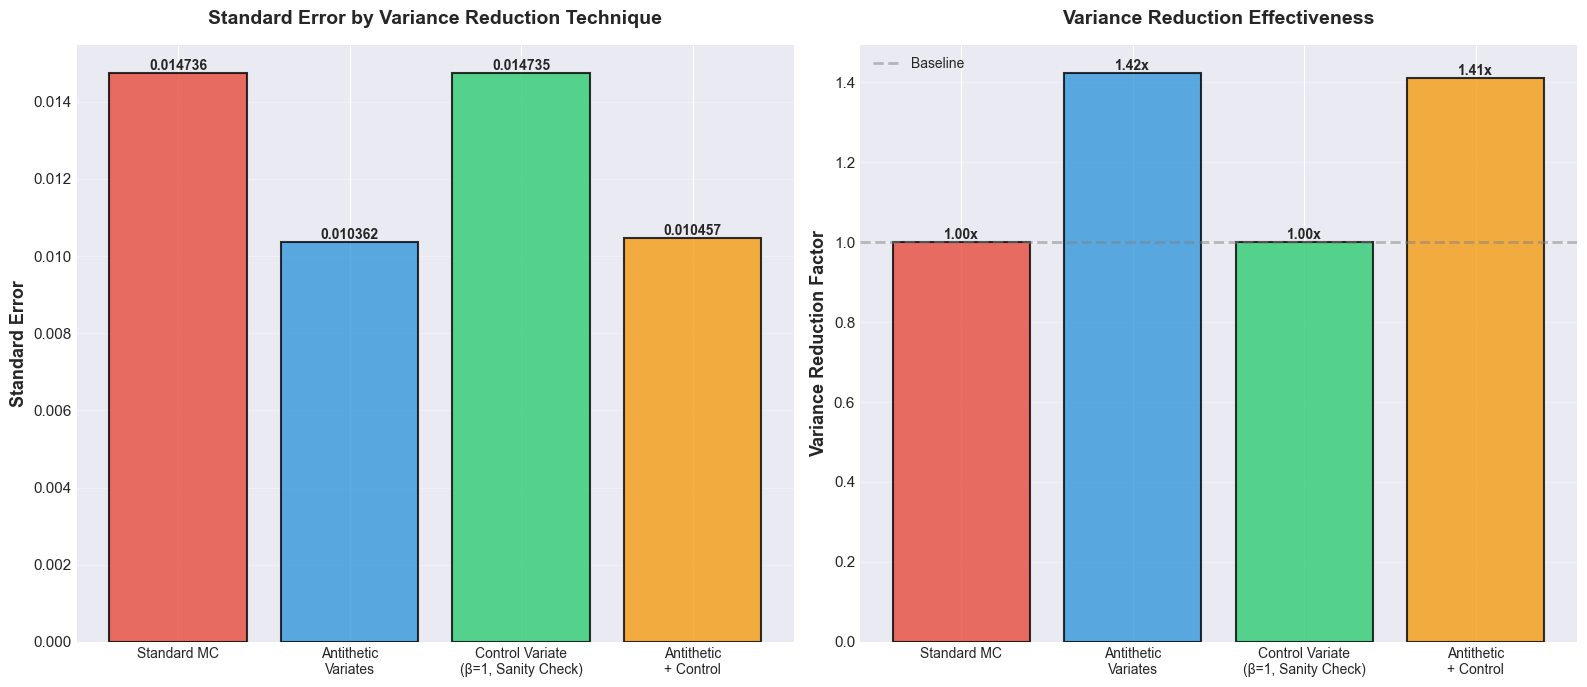


Best technique: Antithetic
Variates with 0.010362 std error
Maximum variance reduction: 1.42x


In [8]:
# Test variance reduction techniques
config.n_paths = 1_000_000
config.n_threads = 8

techniques = [
    ("Standard MC", False, False),
    ("Antithetic\nVariates", True, False),
    ("Control Variate\n(β=1, Sanity Check)", False, True),
    ("Antithetic\n+ Control", True, True),
]

technique_names = []
std_errors_vr = []
prices = []
vr_factors = []

print("Testing variance reduction techniques...\n")
base_std_error = None

for name, use_anti, use_cv in techniques:
    config.use_antithetic = use_anti
    config.use_control_variate = use_cv
    
    result = pricer.price_mc_parallel(config)
    
    technique_names.append(name)
    std_errors_vr.append(result.std_error)
    prices.append(result.price)
    
    if base_std_error is None:
        base_std_error = result.std_error
        vr_factor = 1.0
    else:
        vr_factor = base_std_error / result.std_error
    
    vr_factors.append(vr_factor)
    
    print(f"{name:<30} Std Error: {result.std_error:.6f}, VR Factor: {vr_factor:.2f}x")
    if use_cv and result.control_variate_used:
        # Check if control variate diagnostics are available (requires rebuilt module)
        if hasattr(result, 'control_beta') and hasattr(result, 'variance_reduction_factor'):
            print(f"  {'└─ Control:':<28} β={result.control_beta:.2f}, Var.Red.={result.variance_reduction_factor:.2f}x")
        else:
            print(f"  {'└─ Control:':<28} Enabled (rebuild module for diagnostics)")

# Create bar plot for standard errors
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Standard Error Comparison
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
bars1 = ax1.bar(range(len(technique_names)), std_errors_vr, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars1, std_errors_vr)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.6f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('Standard Error', fontsize=13, fontweight='bold')
ax1.set_title('Standard Error by Variance Reduction Technique', fontsize=14, fontweight='bold', pad=15)
ax1.set_xticks(range(len(technique_names)))
ax1.set_xticklabels(technique_names, fontsize=10)
ax1.grid(True, axis='y', alpha=0.3)

# Plot 2: Variance Reduction Factor
bars2 = ax2.bar(range(len(technique_names)), vr_factors, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars2, vr_factors)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2f}x',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add reference line at 1.0
ax2.axhline(y=1.0, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')

ax2.set_ylabel('Variance Reduction Factor', fontsize=13, fontweight='bold')
ax2.set_title('Variance Reduction Effectiveness', fontsize=14, fontweight='bold', pad=15)
ax2.set_xticks(range(len(technique_names)))
ax2.set_xticklabels(technique_names, fontsize=10)
ax2.grid(True, axis='y', alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nBest technique: {technique_names[std_errors_vr.index(min(std_errors_vr))]} with {min(std_errors_vr):.6f} std error")
print(f"Maximum variance reduction: {max(vr_factors):.2f}x")

## Terminal Distribution & Payoff Mapping (50k samples)

Visualize simulated terminal prices and their discounted payoffs. Uses the CLI dump mode when available (`--dump-st N --out file`), and falls back to a NumPy simulation with the same dynamics if the binary is not found.

In [9]:
# Generate/load terminal samples (N=50k) for visualization
import os
import subprocess
import sys
import numpy as np

n_samples = 50_000
strike = config.K
out_file = "st_dump.csv"

# Possible CLI locations (adjust if you built elsewhere)
exe_candidates = [
    os.path.join("build", "src", "Release", "mc_pricer_cli.exe"),
    os.path.join("build", "src", "Debug", "mc_pricer_cli.exe"),
    os.path.join("build", "Release", "mc_pricer_cli.exe"),
    os.path.join("build", "Debug", "mc_pricer_cli.exe"),
    "mc_pricer_cli.exe",
    os.path.join("build", "src", "Release", "montecarlo_pricer.exe"),
    os.path.join("build", "Release", "montecarlo_pricer.exe"),
]

def try_dump_with_cli():
    for exe in exe_candidates:
        if os.path.isfile(exe):
            cmd = [exe, "--dump-st", str(n_samples), "--out", out_file]
            print("Running:", " ".join(cmd))
            res = subprocess.run(cmd, capture_output=True, text=True)
            if res.returncode == 0:
                if res.stdout.strip():
                    print(res.stdout.strip())
                return True
            else:
                print(f"CLI failed ({exe}): {res.stderr.strip()}")
    return False

# Attempt CLI dump first
used_cli = try_dump_with_cli()

if used_cli:
    data = np.loadtxt(out_file, delimiter=",", skiprows=1)
    ST = data[:, 0]
    payoff = data[:, 1]
    disc_payoff = data[:, 2]
else:
    print("CLI dump unavailable; generating sample with NumPy (same GBM dynamics).")
    rng = np.random.default_rng(42)
    S0 = config.S0
    r = config.r
    sigma = config.sigma
    T = config.T
    drift = (r - 0.5 * sigma * sigma) * T
    diffusion = sigma * np.sqrt(T)
    Z = rng.normal(size=n_samples)
    ST = S0 * np.exp(drift + diffusion * Z)
    payoff = np.maximum(ST - strike, 0.0)
    disc_payoff = np.exp(-r * T) * payoff
    np.savetxt(out_file, np.column_stack([ST, payoff, disc_payoff]), delimiter=",", header="ST,payoff,discounted_payoff", comments="")
    print(f"Saved fallback sample to {out_file} (N={n_samples}).")

sample_price = float(np.mean(disc_payoff))
price_std = float(np.std(disc_payoff, ddof=1))
sample_std_error = price_std / np.sqrt(n_samples)

print(f"Samples: {len(ST)} | Mean price: {sample_price:.6f} | Std error: {sample_std_error:.6f}")

CLI dump unavailable; generating sample with NumPy (same GBM dynamics).
Saved fallback sample to st_dump.csv (N=50000).
Samples: 50000 | Mean price: 10.457692 | Std error: 0.066143


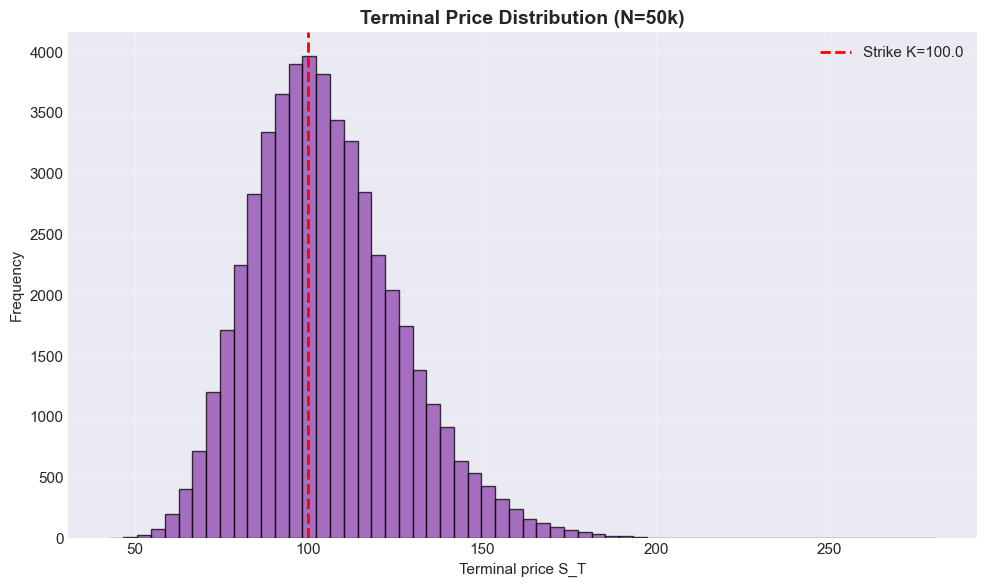

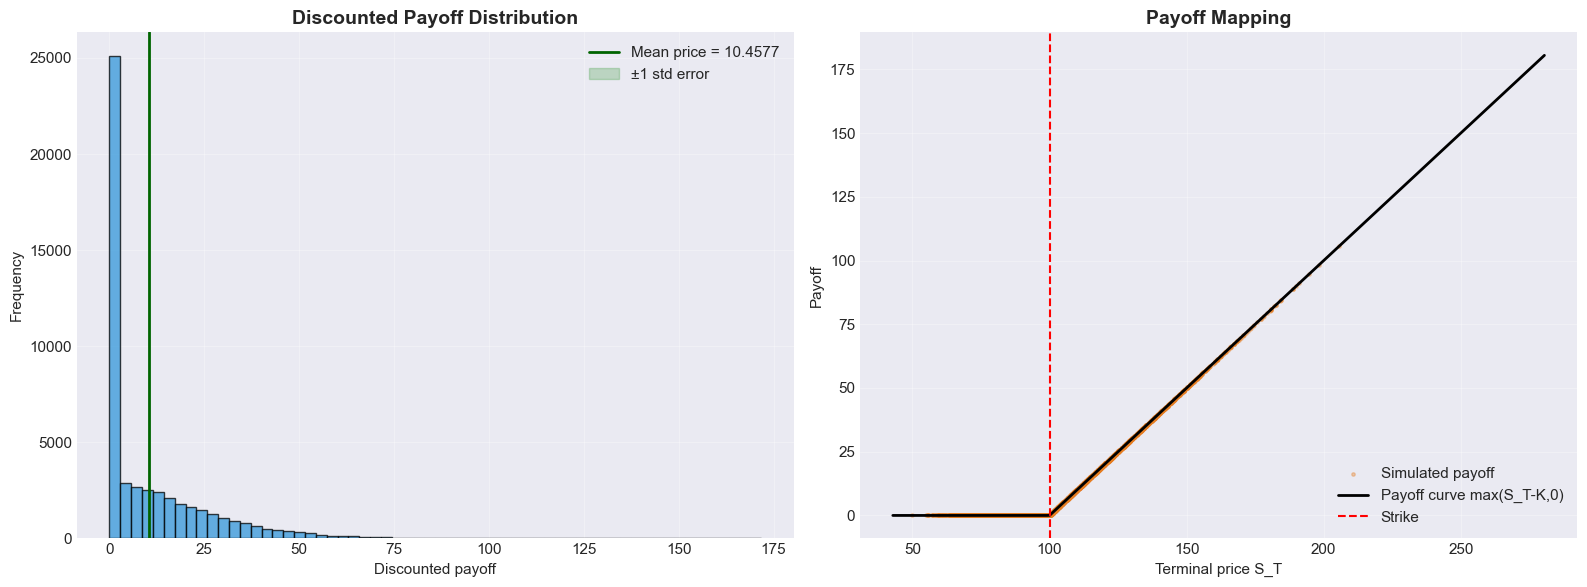

Mean price: 10.457692 | Std error: 0.066143 | N=50000


In [10]:
# Plot terminal distribution and payoff mapping
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ST, bins=60, color='#8e44ad', alpha=0.75, edgecolor='black')
ax.axvline(strike, color='red', linestyle='--', linewidth=2, label=f'Strike K={strike}')
ax.set_title('Terminal Price Distribution (N=50k)', fontsize=14, fontweight='bold')
ax.set_xlabel('Terminal price S_T')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Discounted payoff histogram + payoff mapping
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of discounted payoffs
ax1.hist(disc_payoff, bins=60, color='#3498db', alpha=0.75, edgecolor='black')
ax1.axvline(sample_price, color='darkgreen', linewidth=2, label=f'Mean price = {sample_price:.4f}')
ax1.axvspan(sample_price - sample_std_error, sample_price + sample_std_error,
            color='green', alpha=0.2, label='±1 std error')
ax1.set_title('Discounted Payoff Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Discounted payoff')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Payoff mapping: S_T vs payoff (subset to avoid overplot)
subset = min(5_000, len(ST))
ax2.scatter(ST[:subset], payoff[:subset], s=6, alpha=0.35, color='#e67e22', label='Simulated payoff')
# Theoretical payoff curve
x_line = np.linspace(max(1e-6, np.min(ST)), np.max(ST), 300)
ax2.plot(x_line, np.maximum(x_line - strike, 0.0), color='black', linewidth=2, label='Payoff curve max(S_T-K,0)')
ax2.axvline(strike, color='red', linestyle='--', linewidth=1.5, label='Strike')
ax2.set_title('Payoff Mapping', fontsize=14, fontweight='bold')
ax2.set_xlabel('Terminal price S_T')
ax2.set_ylabel('Payoff')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean price: {sample_price:.6f} | Std error: {sample_std_error:.6f} | N={len(ST)}")

## Full Price Paths (1Y, 252 steps)

Simulate 50–200 Monte Carlo paths over 1 year of daily steps. We plot a subset of paths plus the mean path with a ±1 standard-deviation band.

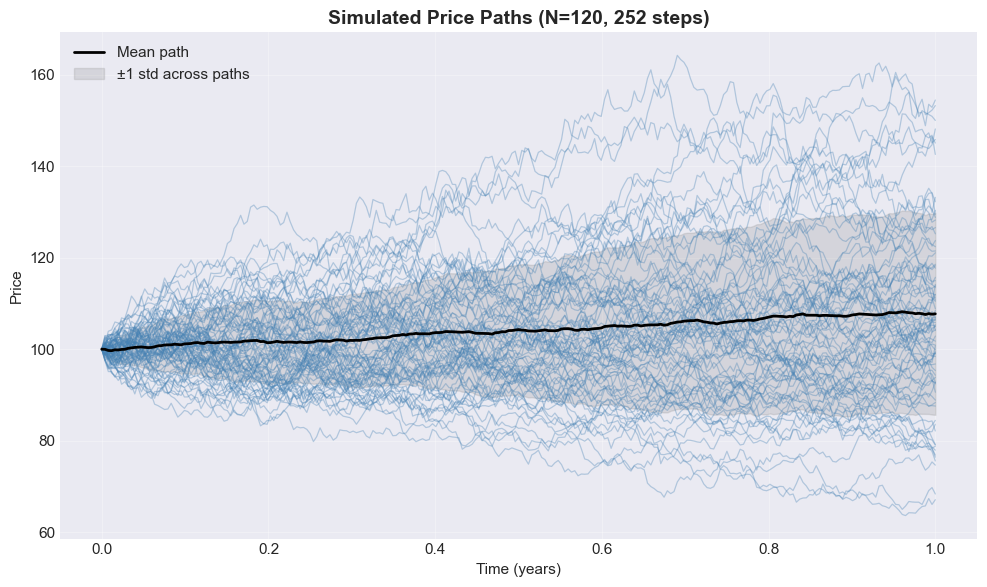

Final S_T mean: 107.7307, std: 22.0823


In [ ]:
# Simulate full price paths (daily over 1 year)
import numpy as np
import matplotlib.pyplot as plt

n_paths_small = 200
n_steps = 252
T = config.T
S0 = config.S0
r = config.r
sigma = config.sigma

dt = T / n_steps
rng_paths = np.random.default_rng(123)
Z = rng_paths.normal(size=(n_paths_small, n_steps))

# Log-Euler scheme for GBM
log_start = np.log(S0)
log_increments = (r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
log_paths = np.cumsum(log_increments, axis=1)
log_paths = np.concatenate([np.zeros((n_paths_small, 1)), log_paths], axis=1) + log_start
paths = np.exp(log_paths)

# Stats across paths at each time step
mean_path = paths.mean(axis=0)
std_path = paths.std(axis=0, ddof=1)
upper_band = mean_path + std_path
lower_band = mean_path - std_path

times = np.linspace(0, T, n_steps + 1)

# Plot a subset of paths
fig, ax = plt.subplots(figsize=(10, 6))
plot_subset = min(80, n_paths_small)
for i in range(plot_subset):
    ax.plot(times, paths[i], color='steelblue', alpha=0.35, linewidth=0.9)

ax.plot(times, mean_path, color='black', linewidth=2, label='Mean path')
ax.fill_between(times, lower_band, upper_band, color='gray', alpha=0.2, label='±1 std across paths')
ax.set_title(f"Simulated Price Paths (N={n_paths_small}, {n_steps} steps)", fontsize=14, fontweight='bold')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Final S_T mean: {paths[:, -1].mean():.4f}, std: {paths[:, -1].std(ddof=1):.4f}")

## Summary: Combined Performance Overview

In [11]:
print("=" * 80)
print("PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\n>>> Configuration:")
print(f"  Stock Price (S0): ${config.S0:.2f}")
print(f"  Strike (K): ${config.K:.2f}")
print(f"  Volatility (σ): {config.sigma*100:.0f}%")
print(f"  Risk-free Rate (r): {config.r*100:.1f}%")
print(f"  Time to Maturity (T): {config.T:.1f} year")
print(f"  Black-Scholes Price: ${analytical_price:.6f}")

print(f"\n>>> Convergence:")
print(f"  Converges at O(1/√N) rate")
print(f"  Error at 1M paths: {errors[path_counts.index(1_000_000)]:.6f}")
print(f"  Error at 5M paths: {errors[-1]:.6f}")

print(f"\n>>> Threading Performance:")
print(f"  Single-threaded: {runtimes[0]:.3f}s")
print(f"  Best multi-threaded: {min(runtimes):.3f}s ({thread_counts[runtimes.index(min(runtimes))]} threads)")
print(f"  Maximum speedup: {max(speedups):.2f}x")
print(f"  Peak efficiency: {max(efficiencies):.1f}%")

print(f"\n>>> Variance Reduction:")
print(f"  Standard MC std error: {std_errors_vr[0]:.6f}")
print(f"  Best technique: {technique_names[std_errors_vr.index(min(std_errors_vr))]}")
print(f"  Best std error: {min(std_errors_vr):.6f}")
print(f"  Maximum improvement: {max(vr_factors):.2f}x")

print("\n" + "=" * 80)

PERFORMANCE SUMMARY

>>> Configuration:
  Stock Price (S0): $100.00
  Strike (K): $100.00
  Volatility (σ): 20%
  Risk-free Rate (r): 5.0%
  Time to Maturity (T): 1.0 year
  Black-Scholes Price: $10.450584

>>> Convergence:
  Converges at O(1/√N) rate
  Error at 1M paths: 0.015186
  Error at 5M paths: 0.001522

>>> Threading Performance:
  Single-threaded: 0.173s
  Best multi-threaded: 0.020s (20 threads)
  Maximum speedup: 8.44x
  Peak efficiency: 100.0%

>>> Variance Reduction:
  Standard MC std error: 0.014736
  Best technique: Antithetic
Variates
  Best std error: 0.010362
  Maximum improvement: 1.42x

